In [1]:
%pylab inline

import numpy as np
import tensorflow as tf
from scipy.integrate import odeint
from ImplicitDenoising import *
from EnKF import *

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


/home/samuel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
n = 40
F = 16.

def shift(x, s):
    if s == 0: return x
    else: return np.concatenate([x[s:], x[:s]])
    
def L96(x,t,params):
    F = params
    return (shift(x,1)-shift(x,-2))*shift(x,-1)-x+F

(0, 500)

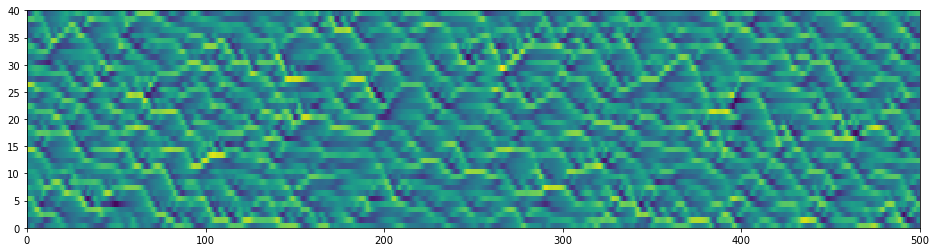

In [4]:
x0 = np.exp(-(np.arange(n)-n/2)**2 / 16)

t = np.arange(0.0, 60.0, 0.05); dt = t[1]-t[0]
X = odeint(L96, x0, t, (F,))[700:,:].T # remove initial transient
t = t[700:]
m = X.shape[1]

figure(figsize = (16,4))
pcolor(X)
xlim(0,m)

In [5]:
def tf_shift(x, s):
    
    n,m = tf.shape(x).eval()
        
    if s == 0: return x
    elif s>0: return tf.concat([tf.slice(x,[s,0],[n-s,m]),tf.slice(x,[0,0],[s,m])], axis = 0)
    else: return tf.concat([tf.slice(x,[n+s,0],[-s,m]),tf.slice(x,[0,0],[n+s,m])], axis = 0)
        
def tf_L96(x, F = F):
    
    n,m = tf.shape(x).eval()
    return (tf_shift(x,1)-tf_shift(x,-2))*tf_shift(x,-1)-x+F

def RK4(x, f, params, h):
    
    b = [1/6,1/3,1/3,1/6]
    A = [[],[1/2],[0, 1/2],[0,0,1]]

    k1 = np.array(f(x, 0, params))
    k2 = np.array(f(x + h*A[1][0]*k1, 0, params))
    k3 = np.array(f(x + h*A[2][0]*k1 + h*A[2][1]*k2, 0, params))
    k4 = np.array(f(x + h*A[3][0]*k1 + h*A[3][1]*k2 + h*A[3][2]*k3, 0, params))
    
    return x+h*(b[0]*k1+b[1]*k2+b[2]*k3+b[3]*k4)

def L96_step(x, h = dt, params = (F)):

    return RK4(x, L96, params, h)

def Identity(x): return x

In [6]:
n_trials = 10                          # number of trials for each method at each noise level
noise_percents = [1,10,20,30,40,50,60,70,80,90,100]  # percent noise to try
Ns = [500]                             # ensemble sizes for EnRTS smoother               

X_hats = {'Implicit' : {nper : [] for nper in noise_percents} , \
         'Implicit_param_est' : {nper : [] for nper in noise_percents} , \
         'EnRTS' : {N : {nper : [] for nper in noise_percents} for N in Ns} }

RMSE = {'Implicit' : np.zeros((n_trials, len(noise_percents))) , \
         'Implicit_param_est' : np.zeros((n_trials, len(noise_percents))) , \
         'EnRTS' : {N : np.zeros((n_trials, len(noise_percents))) for N in Ns} }

Learned_F = {nper : [] for nper in noise_percents}

for j in range(len(noise_percents)):
    noise_percent = noise_percents[j]
    
    for trial in range(n_trials):
    
        print('Testing with', noise_percent, 'percent noise trial', trial+1, 'of', n_trials)

        ####################################################################################################
        #
        # Add in artificial noise
        #
        ####################################################################################################
        noise_level = 0.01*noise_percent*np.var(X)
        measurement_noise = np.sqrt(noise_level)*np.random.randn(n,m)
        Y = X + measurement_noise

        ####################################################################################################
        #
        # Smooth via implicit method
        #
        ####################################################################################################
        tf.reset_default_graph()
        sess = tf.InteractiveSession()

        optimizer, X_hat_tf, cost = create_computational_graph(Y, t, tf_L96, method = 'Gauss3')

        init = tf.global_variables_initializer()
        sess.run(init)

        optimizer.minimize(sess)
        X_hat = X_hat_tf.eval()

        X_hats['Implicit'][noise_percent].append(X_hat)
        RMSE['Implicit'][trial, j] = np.mean((X - X_hat)**2)

        sess.close()

        ####################################################################################################
        #
        # Smooth via implicit method with parameter estimation
        #
        ####################################################################################################
        tf.reset_default_graph()
        sess = tf.InteractiveSession()

        F_hat = tf.get_variable(shape = [1], dtype = tf.float32, name = 'F_hat')
        tf_L96_param_est = lambda x : tf_L96(x, F_hat)

        optimizer, X_hat_tf, cost = create_computational_graph(Y, t, tf_L96_param_est, method = 'Gauss3')

        init = tf.global_variables_initializer()
        sess.run(init)

        optimizer.minimize(sess)
        X_hat = X_hat_tf.eval()

        X_hats['Implicit_param_est'][noise_percent].append(X_hat)
        RMSE['Implicit_param_est'][trial, j] = np.mean((X - X_hat)**2)
        Learned_F[trial, j] = F_hat.eval()

        sess.close()

        ####################################################################################################
        #
        # Smooth via EnRTS for each ensemble size
        #
        ####################################################################################################

        for N in Ns:

            if noise_percent != 0: noise_cov = noise_level*np.eye(n)
            else: noise_cov = 1e-5*np.eye(n) # assume very small noise
                
            stepper_cov = (dt**4)**2*np.eye(n) # square of fourth order time-stepper.  Seems to not matter much

            try:
                _,_,Es = EnRTS(Y, L96_step, Identity, Y[:,0], noise_cov, noise_cov, stepper_cov, N)
                X_hats['EnRTS'][N][noise_percent].append(Es) # save ensemble, not average
                RMSE['EnRTS'][N][trial, j] = np.mean((X - Es.mean(1))**2)
            
            except:
                print('SVD in EnRTS did not converge')
                X_hats['EnRTS'][N][noise_percent].append(None)
                RMSE['EnRTS'][N][trial, j] = np.nan


Testing with 1 percent noise trial 1 of 10
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000067
  Number of iterations: 7081
  Number of functions evaluations: 7153
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000134
  Number of iterations: 11305
  Number of functions evaluations: 12195
Testing with 1 percent noise trial 2 of 10
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000070
  Number of iterations: 6922
  Number of functions evaluations: 6958
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000122
  Number of iterations: 11437
  Number of functions evaluations: 12398
Testing with 1 percent noise trial 3 of 10
INFO:tensor

In [6]:
save_path = "./saved_data/"

# Save results to JSON files
if False:

    np.save(save_path+"L96_testing_Xhat.npy", X_hats)
    np.save(save_path+"L96_testing_RMSE.npy", RMSE)
    np.save(save_path+"L96_testing_F_hats.npy", Learned_F)
    
# Load results from JSON files
if True:
    
    noise_percents = [1,10,20,30,40,50,60,70,80,90,100]
    Ns = [500]

#     X_hats = np.load(save_path+"L96_testing_Xhat.npy")#.item()
    RMSE = np.load(save_path+"L96_testing_RMSE.npy").item()
#     Learned_F = np.load(save_path+"L96_testing_F_hats.npy")#.item()


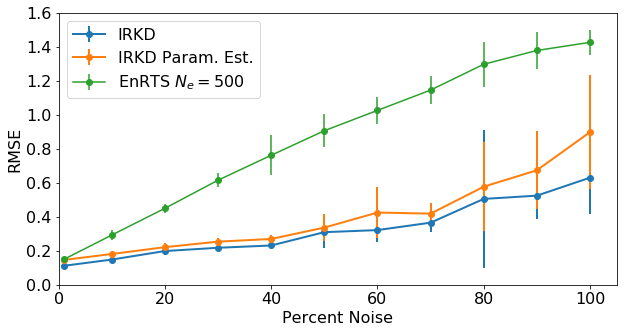

In [8]:
figure(figsize = (10,5))

#
# RMSE for implicit denoising
#
rmse = np.sqrt(RMSE['Implicit'])
errorbar(noise_percents, rmse.mean(0), yerr=rmse.std(0),\
         fmt='-o', label = 'IRKD', linewidth = 2)

#
# RMSE for implicit denoising with parameter estimation
#
rmse = np.sqrt(RMSE['Implicit_param_est'])
errorbar(noise_percents, rmse.mean(0), yerr=rmse.std(0), \
         fmt='-o', label = 'IRKD Param. Est.', linewidth = 2)

#
# RMSE for EnRTS
#
for N in Ns:    
    rmse = np.sqrt(RMSE['EnRTS'][N])
    errorbar(noise_percents, rmse.mean(0), yerr=rmse.std(0), fmt='-o', label = r'EnRTS $N_e=500$')
    
xlabel('Percent Noise', fontsize = 16)
ylabel('RMSE', fontsize = 16)

xticks(fontsize = 16)
yticks(fontsize = 16)

xlim([0,105])

ylim([0,1.6])

legend(loc = 'upper left', fontsize = 16)